## Одномерное уравнение переноса
Для первичного тестирования численных схем часто используют одномерное уравнение переноса. Пусть ветер дует только вдоль оси $x$ и постоянен, $v_x = c$, предположим также периодичские граничные условия:
\begin{align}
&\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0, \ x \in [0,2\pi), \ c>0, \\
&u(t,0) = u(t,2\pi).
\end{align}


Для одномерного уравнения переноса с постоянной скоростью есть аналитическое решение. Если $u(t=0,x) = u_0(x)$, то
\begin{equation}
u(t,x) = u_0(x-ct)
\end{equation}

## Простейшая численная схема

Рассмотрим простейший вариант для аппроксимации этого уравнения. 
Для аппроксимации по пространству можно воспользоваться схемой центральных разностей:
\begin{align}
\frac{u_{i+1}(t)-u_{i-1}(t)}{2\Delta x}.
\end{align}
После чего получаем систему ОДУ:
$$\frac{\mathrm{d} u_i(t)}{\mathrm{d} t} + с \frac{u_{i+1}(t)-u_{i-1}(t)}{2\Delta x}=0. $$

Далее для решения получившейся системы ОДУ можно применять различные методы интегрирования по времени.

Перейдем к программной реализации. Будем использовать равномерную сетку на периодическом отрезке $x \in [0,L)$. Количество узлов сетки $N_x+1$, шаг сетки $\Delta x = L/N_x$, узлы сетки $x_i = (i-1)\Delta x$, $i=0 \dots N_x$. Решаем уравнение при $t \in [0, T]$, количество шагов по времени $N_t$, $t_n = n \Delta t$, $n=0 \dots N_t$.

In [1]:
# Подключаем необходимые пакеты
import numpy as np    
import matplotlib.pyplot  as plt
from matplotlib import animation
%matplotlib notebook

Реализуем процедуру для вычисления производной по пространству.

In [2]:
def centralDifference(f, dx):
    diff_f = np.empty_like(f)
    diff_f[0] = (f[1]-f[-2])/2/dx # т.к. отрезок периодический f(-dx) = f(L-dx)
    for i in range(1, f.size-1):
        diff_f[i] = (f[i+1]-f[i-1]) / 2 / dx
    diff_f[-1] = diff_f[0] # т.к. отрезок периодический x0 = xn, f'_0 = f'_n
    return diff_f

Функция для выполнения шага по времени при помощи явного метода Эйлера.

In [3]:
def explicitEulerStep(state, func, dt):
    return state + dt*func(state) 

In [4]:
def rk4(state, func, dt):
    Y=[0,0,0,0]
    Y[0]=state
    Y[1]=state+dt/2*func(Y[0])
    Y[2]=state+dt/2*func(Y[1])
    Y[3]=state+dt*func(Y[2])
    return state+dt/6*(func(Y[0])+2*func(Y[1])+2*func(Y[2])+func(Y[3]))

In [5]:
def LSRK_inviscid(state,func,dt):
    A=[0.0000000000000000,
        -0.0923311242368072,
        -0.9441056581158819,
        -4.3271273247576394,
        -2.1557771329026072,
        -0.9770727190189062,
        -0.7581835342571139,
        -1.7977525470825499,
        -2.6915667972700770,
        -4.6466798960268143,
        -0.1539613783825189,
        -0.5943293901830616]
    B=[0.0650008435125904,
        0.0161459902249842,
        0.5758627178358159,
        0.1649758848361671,
        0.3934619494248182,
        0.0443509641602719,
        0.2074504268408778,
        0.6914247433015102,
        0.3766646883450449,
        0.0757190350155483,
        0.2027862031054088,
        0.2167029365631842]
    c=[0.0000000000000000,
        0.0650008435125904,
        0.0796560563081853,
        0.1620416710085376,
        0.2248877362907778,
        0.2952293985641261,
        0.3318332506149405,
        0.4094724050198658,
        0.6356954475753369,
        0.6806551557645497,
        0.7143773712418350,
        0.9032588871651854]
    s=len(A)
    K1=state
    K2=0
    for i in range(s):
        K2=A[i]*K2+dt*func(K1)
        K1+=B[i]*K2
    return K1

Функция для решения уравнения переноса. 

In [6]:
def solveAdvection(u0, timeMethod, spaceMethod, nx = 100, nt = 200, L = 1.0, T = 1.0, c = 1.0):
    """
    Входные аргументы:
    u0 -- функция для вычисления начального значения u(t=0,x)
    timeMethod -- функция, метод интегрирования по времени
    spaceMethod -- функция, метод аппроксимации du/dx
    nx -- индекс последнего узла сетки x_i по пространству. i = 0 ... nx, x_0 = x_nx, т.к. отрезок периодический.
    nt -- индекс последнего узла сетки t_i по времени. i = 0 ... nt, t_nt = T
    L -- длина отрезка по пространству
    T -- до какого момента времени производить интегрирование
    с -- скорость адвекции
    """
    
    # параметры пространственной сетки
    dx = L / nx
    x = np.arange(0, nx + 1) * dx
    # параметры временной сетки
    dt = T / nt
    t = np.arange(0, nt + 1) * dt
    # число Куранта
    CFL = c * dt / dx
    print(f"Число Куранта CFL = {CFL}")
    
    # инициализируем массивы для хранения численного и точного решения во все моменты времени
    u = np.zeros((nt+1, nx+1))
    uExact = np.zeros((nt+1, nx+1))
    # задаем решение в начальный момент времени
    u[0,:] = u0(x)
    uExact[0,:] = u0(x)
    # цикл по времени
    for k in range(nt):
        u[k+1,:] = timeMethod(u[k,:], lambda u: -c*spaceMethod(u, dx), dt)
        uExact[k+1, :] = u0((x-c*t[k+1])%np.max(x))
        
    return u, uExact, x, t

Функции для задания начального профиля.

In [7]:
def gaussianHill(x, mean = 0.5, sigma = 10):
    return np.exp(-sigma**2*(x-mean)**2)

Функция для отрисовки численного и точного решения

In [8]:
# Подключаем необходимые пакеты
import numpy as np    
import matplotlib.pyplot  as plt
from matplotlib import animation
%matplotlib notebook

def animateAdvection(u, uExact, x, t,timespeed=1, animSpeed = 1,name='default_name',save=False):
#    plt.ioff()
    fig, ax = plt.subplots()
    line1, = ax.plot(x, u[0,:], label = "Numerical Solution")
    line2, = ax.plot(x,uExact[0,:], label = "Exact Solution") 
    lines = (line1, line2)
    
    fig.legend(loc = 8, ncol = 2) 
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    
    height = np.max(np.abs(u[0,:]))
    ax.set_ylim(np.min(u[0, :]) - 0.2 * height, np.max(u[0, :]) + 0.2 * height)

    time_template = 'time = %.4fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    def init():
        return lines
    
    def animate(n):
        nAnim = animSpeed * n
        lines[0].set_ydata(u[nAnim,:])
        lines[1].set_ydata(uExact[nAnim,:])
        time_text.set_text(time_template % (t[nAnim]))
        return lines, time_text

    anim = animation.FuncAnimation(fig, animate,init_func=init, frames=len(t), interval=10/timespeed,repeat_delay=2000, repeat = True, blit=True)
    if (save == True):
        anim.save(name+".gif", writer='imagemagick')
    return anim

# RK4

С семинаров известно, что для $RK4$ число курранта не превышает примерно $2.8$

### Устойчиво

Число Куранта CFL = 2.5


<IPython.core.display.Javascript object>


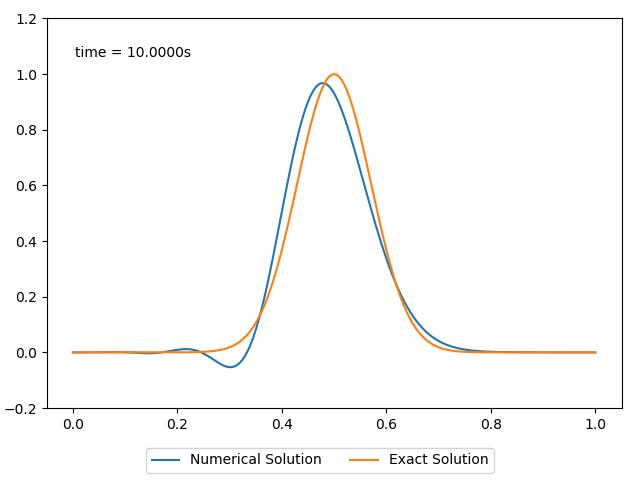

In [61]:
u, uExact, x, t = solveAdvection(gaussianHill, rk4, centralDifference, nx = 200, nt = 800, c=1.0,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

### Не устойчиво

Число Куранта CFL = 2.844950213371266


<IPython.core.display.Javascript object>


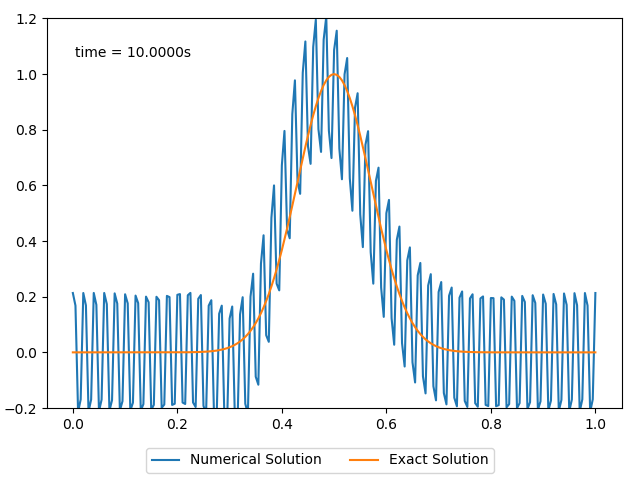

In [62]:
u, uExact, x, t = solveAdvection(gaussianHill, rk4, centralDifference, nx = 200, nt = 703, c=1.0,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Число стадий 4, число Курранта в районе 2.84

In [11]:
rk4_currant=2.8/4
rk4_currant

0.7

# Теперь тест нашего алгоритма

Число Куранта CFL = 2.857142857142857


<IPython.core.display.Javascript object>


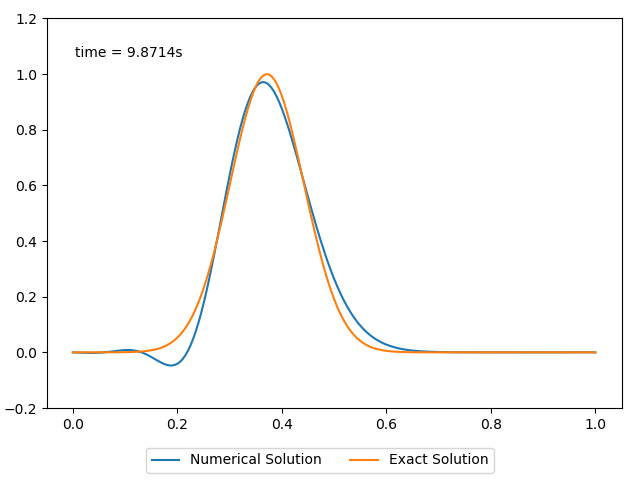

In [63]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 700, c=1.0,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

RK4 прожевать он смог, будем теперь бинпоиском искать число Курранта

Число Куранта CFL = 10.0


<IPython.core.display.Javascript object>


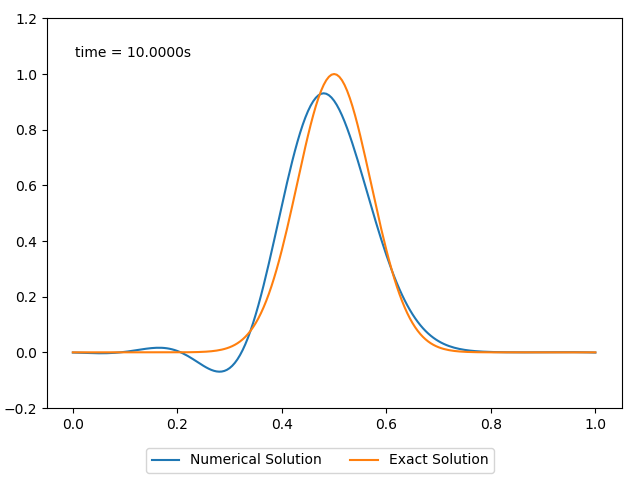

In [64]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.0,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Больше десяти

Число Куранта CFL = 11.000000000000002


<IPython.core.display.Javascript object>


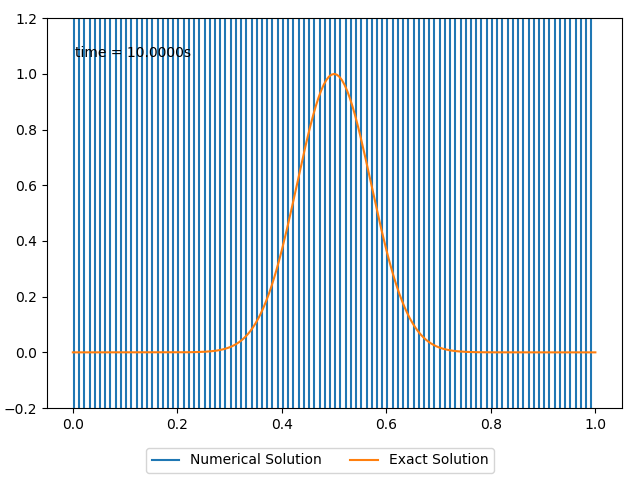

In [65]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.1,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Меньше 11

Число Куранта CFL = 10.5


<IPython.core.display.Javascript object>


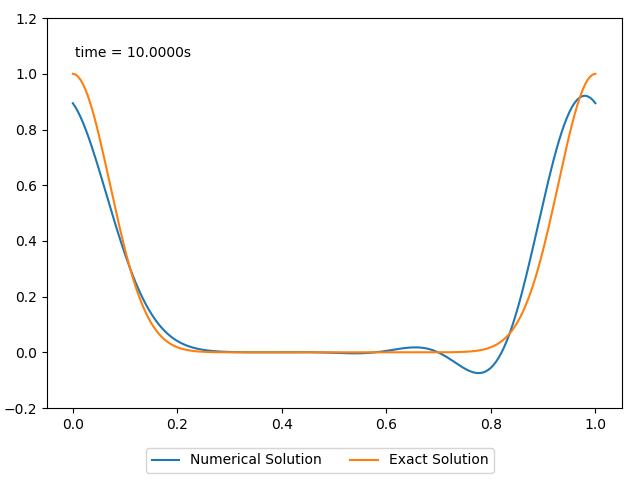

In [66]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.05,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Число Куранта CFL = 10.75


<IPython.core.display.Javascript object>


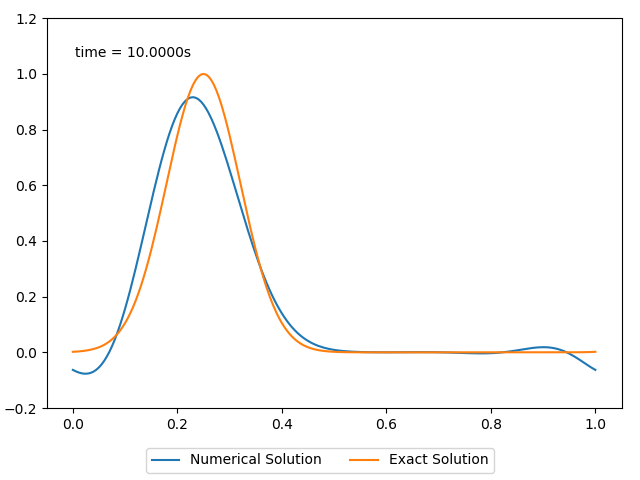

In [67]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.075,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Число Куранта CFL = 10.870000000000001


<IPython.core.display.Javascript object>


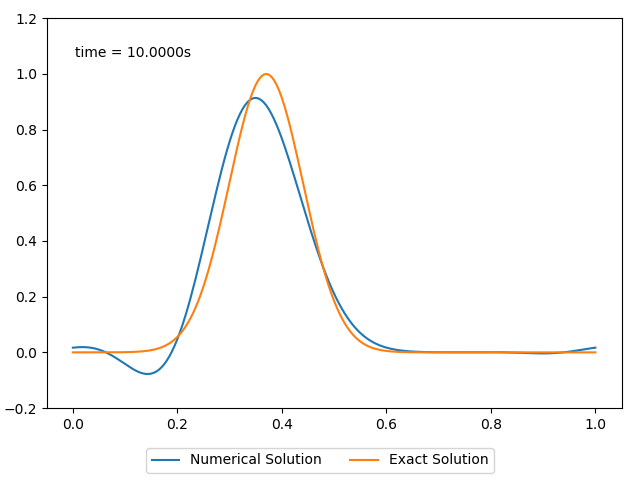

In [68]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.087,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Число Куранта CFL = 10.95


<IPython.core.display.Javascript object>


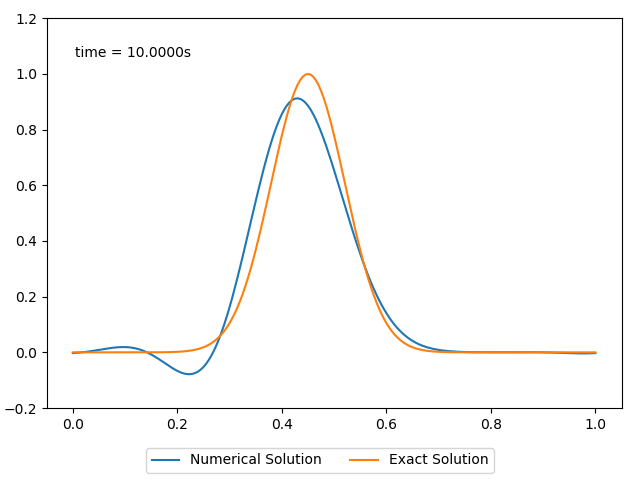

In [69]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.095,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Итого $\sigma = 10.975 \pm 00.030$

Число Курранта 10.9, число стадий 12

In [27]:
sch12_currant=10.9/12
sch12_currant

0.9083333333333333

Напомним, что у RK4 было

In [28]:
rk4_currant

0.7

__Вывод__ : в рассчете на один шаг, у _рассматриваемого алгоритма_ число курранта больше, чем у _RK4_

## Замеры по времени RK4 vs Алгоритм

In [37]:
times=[1000,1500,2000,4000,6000,8000,10000,15000,20000]

In [38]:
import time
times_rk4=[]
times_LSRK=[]

for nt in times:
    iteration_start=time.time()
    solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 500, nt = nt, c=1.0,T=5)
    iteration_end=time.time()
    times_LSRK.append(iteration_end-iteration_start)
    
    iteration_start=time.time()
    solveAdvection(gaussianHill, rk4, centralDifference, nx = 500, nt = nt, c=1.0,T=5)
    iteration_end=time.time()
    times_rk4.append(iteration_end-iteration_start)    

Число Куранта CFL = 2.5
Число Куранта CFL = 2.5
Число Куранта CFL = 1.6666666666666667
Число Куранта CFL = 1.6666666666666667
Число Куранта CFL = 1.25
Число Куранта CFL = 1.25
Число Куранта CFL = 0.625
Число Куранта CFL = 0.625
Число Куранта CFL = 0.4166666666666667
Число Куранта CFL = 0.4166666666666667
Число Куранта CFL = 0.3125
Число Куранта CFL = 0.3125
Число Куранта CFL = 0.25
Число Куранта CFL = 0.25
Число Куранта CFL = 0.16666666666666666
Число Куранта CFL = 0.16666666666666666
Число Куранта CFL = 0.125
Число Куранта CFL = 0.125


<IPython.core.display.Javascript object>


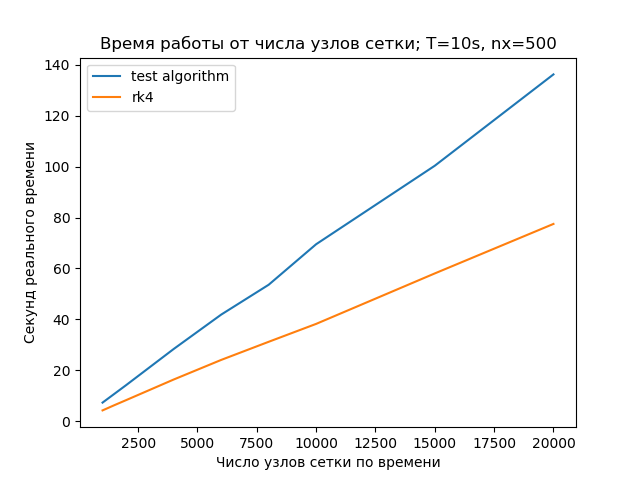

Text(0.5,1,'Время работы от числа узлов сетки; T=10s, nx=500')

In [60]:
plt.close()
%matplotlib notebook
plt.plot(times,times_LSRK,label='test algorithm')
plt.plot(times,times_rk4,label='rk4')
plt.legend()
plt.ylabel("Секунд реального времени")
plt.xlabel("Число узлов сетки по времени")
plt.title("Время работы от числа узлов сетки; T=10s, nx=500")

__Вывод__ : как и предполагалось, _RK4_ быстрее, это объясняется тем, что он делает банально меньше операций. Но сравнение не особо осмысленное, надо попробовать их нагрузить одинаково - ведь здесь _наш алгоритм_ работает по сути вхолостую, при таких числах Курранта. Интересно что даже так, замедление происходит не больше чем в два раза.